In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.model_selection import StratifiedKFold,KFold, train_test_split
import warnings
from sklearn import preprocessing
warnings.filterwarnings("ignore")

In [2]:
data = pd.read_csv('https://raw.githubusercontent.com/leandrodinizsilva/tp-icd/main/data.csv',
                 sep=',',
                 header=0)
data.head()

,Unnamed: 0,ID,Name,Age,Photo,Nationality,Flag,Overall,Potential,Club,...,Composure,Marking,StandingTackle,SlidingTackle,GKDiving,GKHandling,GKKicking,GKPositioning,GKReflexes,Release Clause
0,0,158023,L. Messi,31,https://cdn.sofifa.org/players/4/19/158023.png,Argentina,https://cdn.sofifa.org/flags/52.png,94,94,FC Barcelona,...,96.0,33.0,28.0,26.0,6.0,11.0,15.0,14.0,8.0,€226.5M
1,1,20801,Cristiano Ronaldo,33,https://cdn.sofifa.org/players/4/19/20801.png,Portugal,https://cdn.sofifa.org/flags/38.png,94,94,Juventus,...,95.0,28.0,31.0,23.0,7.0,11.0,15.0,14.0,11.0,€127.1M
2,2,190871,Neymar Jr,26,https://cdn.sofifa.org/players/4/19/190871.png,Brazil,https://cdn.sofifa.org/flags/54.png,92,93,Paris Saint-Germain,...,94.0,27.0,24.0,33.0,9.0,9.0,15.0,15.0,11.0,€228.1M
3,3,193080,De Gea,27,https://cdn.sofifa.org/players/4/19/193080.png,Spain,https://cdn.sofifa.org/flags/45.png,91,93,Manchester United,...,68.0,15.0,21.0,13.0,90.0,85.0,87.0,88.0,94.0,€138.6M
4,4,192985,K. De Bruyne,27,https://cdn.sofifa.org/players/4/19/192985.png,Belgium,https://cdn.sofifa.org/flags/7.png,91,92,Manchester City,...,88.0,68.0,58.0,51.0,15.0,13.0,5.0,10.0,13.0,€196.4M


In [3]:
plt.rcParams['figure.figsize']  = (18, 10)
plt.rcParams['axes.labelsize']  = 20
plt.rcParams['axes.titlesize']  = 20
plt.rcParams['legend.fontsize'] = 20
plt.rcParams['xtick.labelsize'] = 20
plt.rcParams['ytick.labelsize'] = 20
plt.rcParams['lines.linewidth'] = 4
plt.ion()

plt.style.use('seaborn-colorblind')
plt.rcParams['figure.figsize']  = (12, 8)


## Processamento de dados

In [4]:
#retirando colunas irrelavantes
data.drop(['Unnamed: 0','ID','Photo', 'Flag', 'Club Logo', 'Loaned From'], axis=1, inplace=True)
cols = [i for i in range(22,49)]
data.drop(data.columns[cols], axis = 1, inplace=True)

#arrumando a altura e o peso
pd.options.display.max_columns = 90
data['Weight'] =  data['Weight'].str[:3].astype(float) /  2.205
data['Height(cm)'] = data['Height'].str.split("'") 
data['Height'] = (12 * data['Height(cm)'].str[0].astype(float) + data['Height(cm)'].str[1].astype(float)) * 2.54
data.drop(['Height(cm)'], axis=1, inplace=True)
data.rename({'Height': 'Height (cm)', 'Weight': 'Weight (kg)'},axis=1, inplace=True)


In [5]:
#arrumando o valor, salário e cláusula de quebra
s = pd.Series(['Value','Wage','Release Clause'])
for i in s:
  data['aux1'] = data[i].str.extract('(€\d+)')
  data['aux1'] = data['aux1'].str.extract('(\d+)')
  data['aux1'] = data['aux1'].astype(float)
  data['aux2'] = data[i].str.extract('(\.\d+)')
  data['aux2'].fillna(0, inplace=True)
  data['aux2'] = data['aux2'].astype(float)
  data[i] = data['aux1'] + data['aux2']
  data.drop(['aux1', 'aux2'],axis=1,inplace=True)

In [6]:
#Arrumando os tipos corporais
data.loc[data['Body Type'] == 'Akinfenwa', 'Body Type'] = 'Stocky'
data.loc[data['Body Type'] == 'Neymar', 'Body Type'] = 'Lean'
data.loc[data['Body Type'] == 'Messi', 'Body Type'] = 'Lean'
data.loc[data['Body Type'] == 'C. Ronaldo', 'Body Type'] = 'Stocky'
data.loc[data['Body Type'] == 'Shaqiri', 'Body Type'] = 'Stocky'
data.loc[data['Body Type'] == 'Courtois', 'Body Type'] = 'Normal'
data.loc[data['Body Type'] == 'PLAYER_BODY_TYPE_25', 'Body Type'] = 'Normal'

#Agora só há três tipos
set(data['Body Type'])

{'Lean', 'Normal', 'Stocky', nan}

In [7]:
#tamanho normal
data.shape

(18207, 56)

In [8]:
#tamanho depois de remover os nulos (diferença de ~1500)
data = data.dropna()
data.shape

(16643, 56)

# Análise Exploratória de Dados

In [9]:
#A "cara" do dataset:
display(data.head())

,Name,Age,Nationality,Overall,Potential,Club,Value,Wage,Special,Preferred Foot,International Reputation,Weak Foot,Skill Moves,Work Rate,Body Type,Real Face,Position,Jersey Number,Joined,Contract Valid Until,Height (cm),Weight (kg),Finishing,HeadingAccuracy,ShortPassing,Volleys,Dribbling,Curve,FKAccuracy,LongPassing,BallControl,Acceleration,SprintSpeed,Agility,Reactions,Balance,ShotPower,Jumping,Stamina,Strength,LongShots,Aggression,Interceptions,Positioning,Vision,Penalties,Composure,Marking,StandingTackle,SlidingTackle,GKDiving,GKHandling,GKKicking,GKPositioning,GKReflexes,Release Clause
0,L. Messi,31,Argentina,94,94,FC Barcelona,110.5,565.0,2202,Left,5.0,4.0,4.0,Medium/ Medium,Lean,Yes,RF,10.0,"Jul 1, 2004",2021,170.18,72.108844,95.0,70.0,90.0,86.0,97.0,93.0,94.0,87.0,96.0,91.0,86.0,91.0,95.0,95.0,85.0,68.0,72.0,59.0,94.0,48.0,22.0,94.0,94.0,75.0,96.0,33.0,28.0,26.0,6.0,11.0,15.0,14.0,8.0,226.5
1,Cristiano Ronaldo,33,Portugal,94,94,Juventus,77.0,405.0,2228,Right,5.0,4.0,5.0,High/ Low,Stocky,Yes,ST,7.0,"Jul 10, 2018",2022,187.96,82.993197,94.0,89.0,81.0,87.0,88.0,81.0,76.0,77.0,94.0,89.0,91.0,87.0,96.0,70.0,95.0,95.0,88.0,79.0,93.0,63.0,29.0,95.0,82.0,85.0,95.0,28.0,31.0,23.0,7.0,11.0,15.0,14.0,11.0,127.1
2,Neymar Jr,26,Brazil,92,93,Paris Saint-Germain,118.5,290.0,2143,Right,5.0,5.0,5.0,High/ Medium,Lean,Yes,LW,10.0,"Aug 3, 2017",2022,175.26,68.027211,87.0,62.0,84.0,84.0,96.0,88.0,87.0,78.0,95.0,94.0,90.0,96.0,94.0,84.0,80.0,61.0,81.0,49.0,82.0,56.0,36.0,89.0,87.0,81.0,94.0,27.0,24.0,33.0,9.0,9.0,15.0,15.0,11.0,228.1
3,De Gea,27,Spain,91,93,Manchester United,72.0,260.0,1471,Right,4.0,3.0,1.0,Medium/ Medium,Lean,Yes,GK,1.0,"Jul 1, 2011",2020,193.04,76.190476,13.0,21.0,50.0,13.0,18.0,21.0,19.0,51.0,42.0,57.0,58.0,60.0,90.0,43.0,31.0,67.0,43.0,64.0,12.0,38.0,30.0,12.0,68.0,40.0,68.0,15.0,21.0,13.0,90.0,85.0,87.0,88.0,94.0,138.6
4,K. De Bruyne,27,Belgium,91,92,Manchester City,102.0,355.0,2281,Right,4.0,5.0,4.0,High/ High,Normal,Yes,RCM,7.0,"Aug 30, 2015",2023,180.34,69.841270,82.0,55.0,92.0,82.0,86.0,85.0,83.0,91.0,91.0,78.0,76.0,79.0,91.0,77.0,91.0,63.0,90.0,75.0,91.0,76.0,61.0,87.0,94.0,79.0,88.0,68.0,58.0,51.0,15.0,13.0,5.0,10.0,13.0,196.4


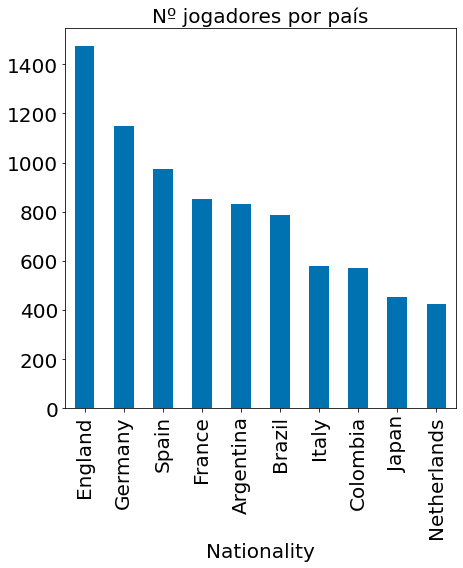

In [10]:
attribute = data.groupby(['Nationality'], as_index = False).count()
#attribute = attribute[['Nationality', 'Name']]
attribute = pd.DataFrame(attribute[['Nationality', 'Name']]).sort_values(by = 'Name', ascending = False)
attribute = attribute[:10]

#attribute['Name'].plot.bar(x = 'Nationality', xlabel = 'País', title = 'Salário médio por nacionalidade', ylabel = 'Valor (milhares de euros)', legend=False, figsize = (7,7))
_ = attribute.plot.bar(x = 'Nationality', title = 'Nº jogadores por país', figsize = (7,7), legend = False)

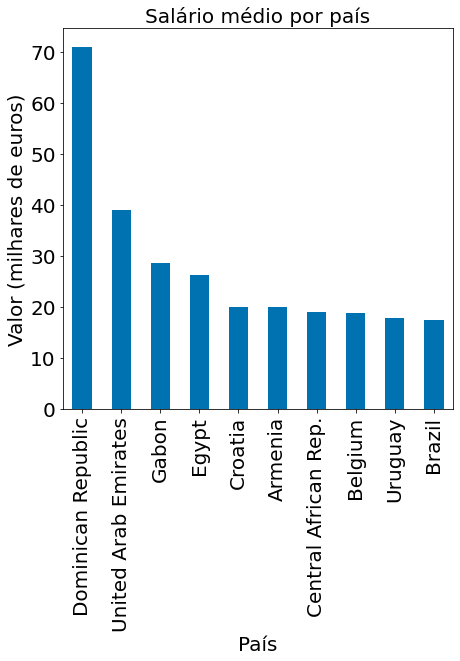

In [11]:
attribute = data.groupby(['Nationality'], as_index = False).mean()
attribute = pd.DataFrame(attribute[['Nationality', 'Wage']]).sort_values(by = 'Wage', ascending = False)
attribute = attribute[:10]

_ = attribute.plot.bar(x = 'Nationality', xlabel = 'País', title = 'Salário médio por país', ylabel = 'Valor (milhares de euros)', legend=False, figsize = (7,7))

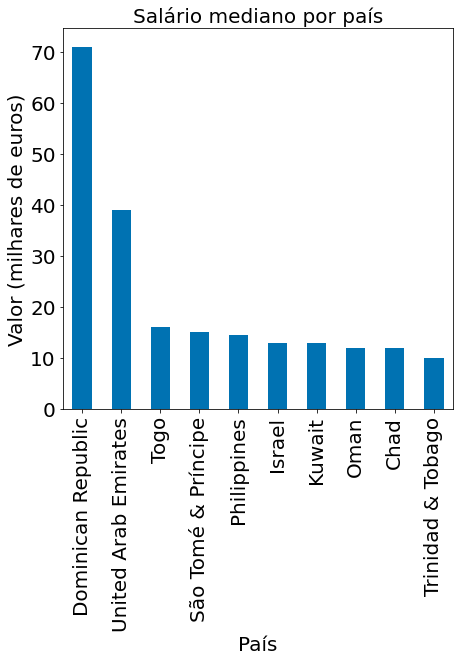

In [12]:
attribute = data.groupby(['Nationality'], as_index = False).median()
attribute = pd.DataFrame(attribute[['Nationality', 'Wage']]).sort_values(by = 'Wage', ascending = False)
attribute = attribute[:10]

_ = attribute.plot.bar(x = 'Nationality', xlabel = 'País', title = 'Salário mediano por país', ylabel = 'Valor (milhares de euros)', legend=False, figsize = (7,7))

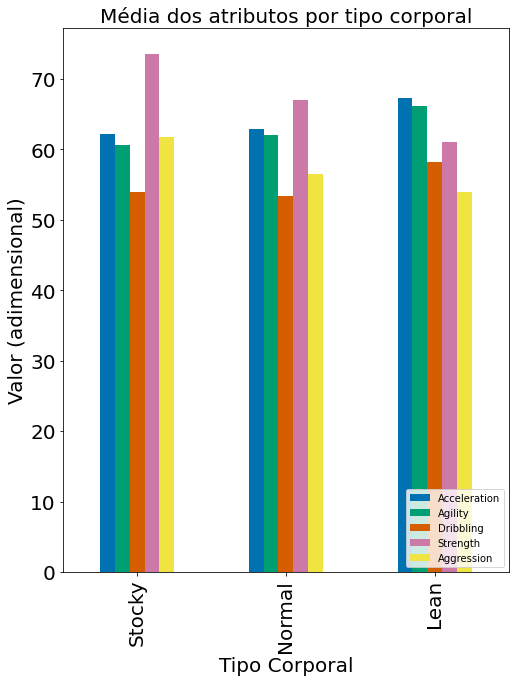

In [13]:
#Médias dos atributos por tipo corporal:
attribute = data.groupby(['Body Type'], as_index = False).mean()

#A maioria das categorias são iguais para todos os grupos, mas essas apresentam algumas diferenças:
attribute = pd.DataFrame(attribute[['Body Type', 'Acceleration', 'Agility', 'Dribbling', 'Strength','Aggression']]).sort_values(by = ['Acceleration', 'Agility', 'Dribbling', 'Strength','Aggression'])

#Percebe-se que os atletas magros são, em média, um pouco mais rápidos, agéis e driblam melhor.
#Os mesormorfos são mais pesados, fortes e agressivos

_ = attribute.plot.bar(x ='Body Type', xlabel = 'Tipo Corporal', ylabel ='Valor (adimensional)', title='Média dos atributos por tipo corporal', figsize = (8,10))
_ = plt.legend(loc = 4, prop = {'size': 10})

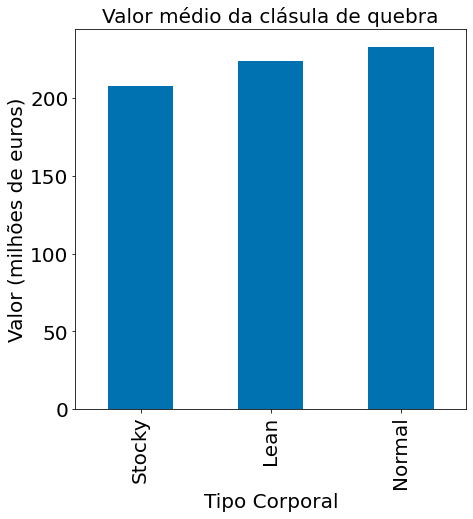

In [14]:
attribute = data.groupby(['Body Type'], as_index = False).mean()
attribute = pd.DataFrame(attribute[['Body Type', 'Release Clause']]).sort_values(by = 'Release Clause')
_ = attribute.plot.bar(x = 'Body Type', xlabel = 'Tipo Corporal', title = 'Valor médio da clásula de quebra', ylabel = 'Valor (milhões de euros)', legend=False, figsize = (7,7))

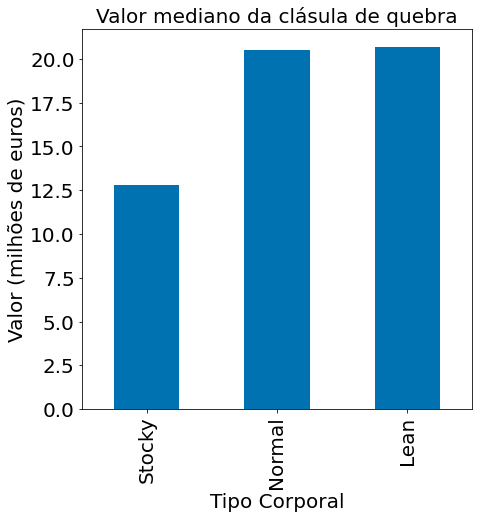

In [15]:
#Vamos considerar as medianas dos mesmos atributos
attribute_median = data.groupby(['Body Type'], as_index = False).median()
attribute_median = pd.DataFrame(attribute_median[['Body Type', 'Release Clause']]).sort_values(by = 'Release Clause')
_ = attribute_median.plot.bar(x = 'Body Type', xlabel = 'Tipo Corporal', title = 'Valor mediano da clásula de quebra', ylabel = 'Valor (milhões de euros)', legend=False, figsize = (7,7))

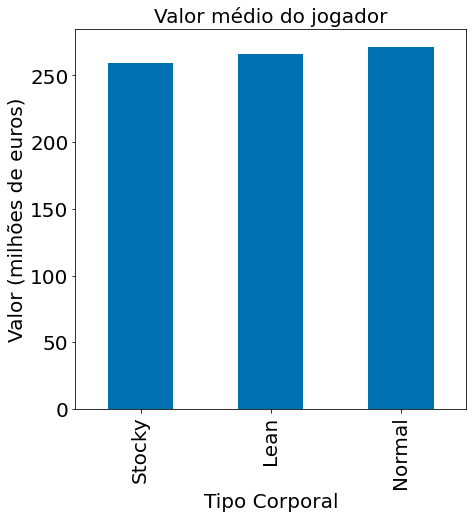

In [16]:
attribute_median = data.groupby(['Body Type'], as_index = False).mean()
attribute_median = pd.DataFrame(attribute_median[['Body Type', 'Value']]).sort_values(by = 'Value')
_ = attribute_median.plot.bar(x = 'Body Type', xlabel = 'Tipo Corporal', title = 'Valor médio do jogador', ylabel = 'Valor (milhões de euros)', legend=False, figsize = (7,7))

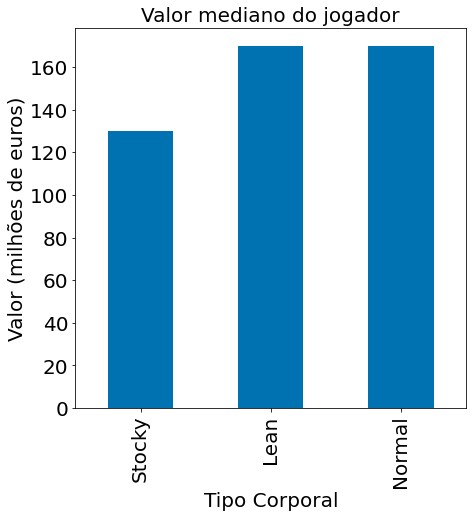

In [17]:
attribute_median = data.groupby(['Body Type'], as_index = False).median()
attribute_median = pd.DataFrame(attribute_median[['Body Type', 'Value']]).sort_values(by = 'Value')
_ = attribute_median.plot.bar(x = 'Body Type', xlabel = 'Tipo Corporal', title = 'Valor mediano do jogador', ylabel = 'Valor (milhões de euros)', legend=False, figsize = (7,7))

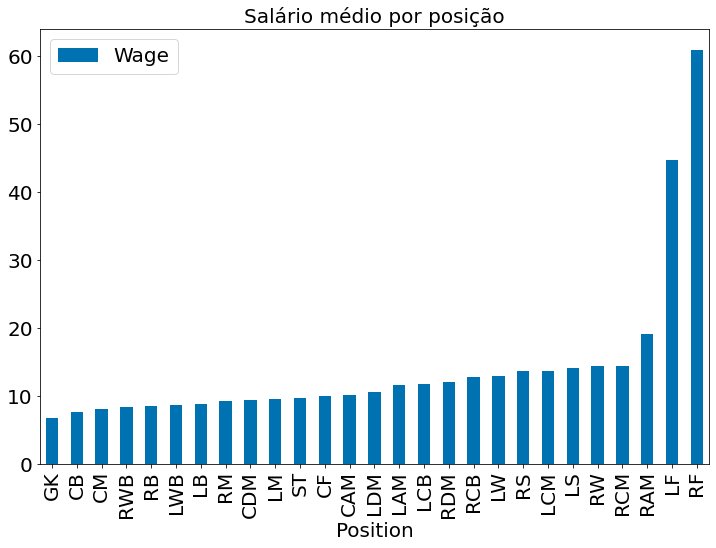

In [18]:
attribute_position = pd.DataFrame(data.groupby(['Position']).mean()['Wage'])
attribute_position = attribute_position.sort_values(by = 'Wage')
_ = attribute_position.plot.bar(title = "Salário médio por posição")

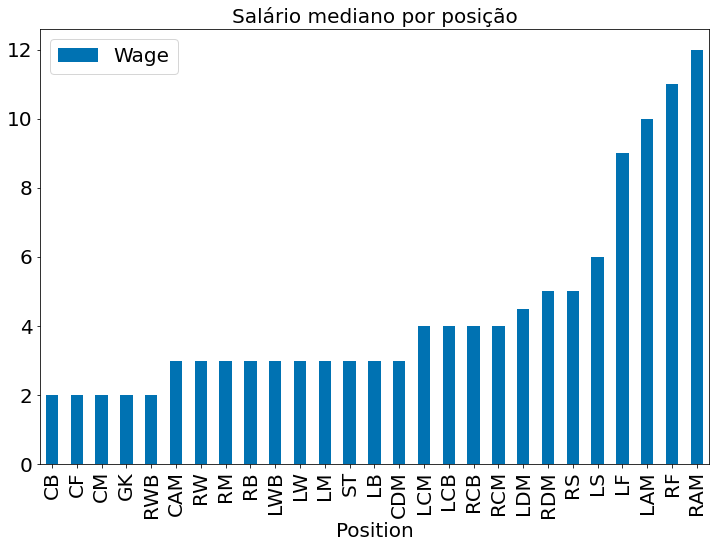

In [19]:
attribute_position = pd.DataFrame(data.groupby(['Position']).median()['Wage'])
attribute_position = attribute_position.sort_values(by = 'Wage')
_ = attribute_position.plot.bar(title = "Salário mediano por posição")

O ponto principal é que a visualização dos dados pode mudar muito dependendo da estatística sendo analisada. Isto é, diferenças que existem na média podem não existir quando consideramos a mediana (e vice-versa).

In [20]:
attribute_position = pd.DataFrame(data.groupby(['Club']).median()['Wage'])
attribute_position.sort_values(by='Wage')

,Wage
Club,
Padova,1.0
Hokkaido Consadole Sapporo,1.0
Derry City,1.0
CD Antofagasta,1.0
Perugia,1.0
...,...
Manchester United,110.0
Real Madrid,120.0
Manchester City,120.0


Os resultados para a mediana são bem menos impressionantes. A diferença aqui é de apenas 7K, enquanto que para a média, era de 42k, seis vezes mais. Como interpretar isso? Muito provavelmente, existem jogadores em RF/LF que estão puxando a média para cima. Na prática, essas posições não são necessariamente as melhores do ponto de vista financeiro.

## Hipótese I



In [21]:
data.loc[data['Position'] == "GK"].sort_values("Height (cm)", ascending=False)
data.sort_values("Height (cm)", ascending=False)

data.head(10)

,Name,Age,Nationality,Overall,Potential,Club,Value,Wage,Special,Preferred Foot,International Reputation,Weak Foot,Skill Moves,Work Rate,Body Type,Real Face,Position,Jersey Number,Joined,Contract Valid Until,Height (cm),Weight (kg),Finishing,HeadingAccuracy,ShortPassing,Volleys,Dribbling,Curve,FKAccuracy,LongPassing,BallControl,Acceleration,SprintSpeed,Agility,Reactions,Balance,ShotPower,Jumping,Stamina,Strength,LongShots,Aggression,Interceptions,Positioning,Vision,Penalties,Composure,Marking,StandingTackle,SlidingTackle,GKDiving,GKHandling,GKKicking,GKPositioning,GKReflexes,Release Clause
0,L. Messi,31,Argentina,94,94,FC Barcelona,110.5,565.0,2202,Left,5.0,4.0,4.0,Medium/ Medium,Lean,Yes,RF,10.0,"Jul 1, 2004",2021,170.18,72.108844,95.0,70.0,90.0,86.0,97.0,93.0,94.0,87.0,96.0,91.0,86.0,91.0,95.0,95.0,85.0,68.0,72.0,59.0,94.0,48.0,22.0,94.0,94.0,75.0,96.0,33.0,28.0,26.0,6.0,11.0,15.0,14.0,8.0,226.5
1,Cristiano Ronaldo,33,Portugal,94,94,Juventus,77.0,405.0,2228,Right,5.0,4.0,5.0,High/ Low,Stocky,Yes,ST,7.0,"Jul 10, 2018",2022,187.96,82.993197,94.0,89.0,81.0,87.0,88.0,81.0,76.0,77.0,94.0,89.0,91.0,87.0,96.0,70.0,95.0,95.0,88.0,79.0,93.0,63.0,29.0,95.0,82.0,85.0,95.0,28.0,31.0,23.0,7.0,11.0,15.0,14.0,11.0,127.1
2,Neymar Jr,26,Brazil,92,93,Paris Saint-Germain,118.5,290.0,2143,Right,5.0,5.0,5.0,High/ Medium,Lean,Yes,LW,10.0,"Aug 3, 2017",2022,175.26,68.027211,87.0,62.0,84.0,84.0,96.0,88.0,87.0,78.0,95.0,94.0,90.0,96.0,94.0,84.0,80.0,61.0,81.0,49.0,82.0,56.0,36.0,89.0,87.0,81.0,94.0,27.0,24.0,33.0,9.0,9.0,15.0,15.0,11.0,228.1
3,De Gea,27,Spain,91,93,Manchester United,72.0,260.0,1471,Right,4.0,3.0,1.0,Medium/ Medium,Lean,Yes,GK,1.0,"Jul 1, 2011",2020,193.04,76.190476,13.0,21.0,50.0,13.0,18.0,21.0,19.0,51.0,42.0,57.0,58.0,60.0,90.0,43.0,31.0,67.0,43.0,64.0,12.0,38.0,30.0,12.0,68.0,40.0,68.0,15.0,21.0,13.0,90.0,85.0,87.0,88.0,94.0,138.6
4,K. De Bruyne,27,Belgium,91,92,Manchester City,102.0,355.0,2281,Right,4.0,5.0,4.0,High/ High,Normal,Yes,RCM,7.0,"Aug 30, 2015",2023,180.34,69.841270,82.0,55.0,92.0,82.0,86.0,85.0,83.0,91.0,91.0,78.0,76.0,79.0,91.0,77.0,91.0,63.0,90.0,75.0,91.0,76.0,61.0,87.0,94.0,79.0,88.0,68.0,58.0,51.0,15.0,13.0,5.0,10.0,13.0,196.4
5,E. Hazard,27,Belgium,91,91,Chelsea,93.0,340.0,2142,Right,4.0,4.0,4.0,High/ Medium,Normal,Yes,LF,10.0,"Jul 1, 2012",2020,172.72,73.922902,84.0,61.0,89.0,80.0,95.0,83.0,79.0,83.0,94.0,94.0,88.0,95.0,90.0,94.0,82.0,56.0,83.0,66.0,80.0,54.0,41.0,87.0,89.0,86.0,91.0,34.0,27.0,22.0,11.0,12.0,6.0,8.0,8.0,172.1
6,L. Modrić,32,Croatia,91,91,Real Madrid,67.0,420.0,2280,Right,4.0,4.0,4.0,High/ High,Lean,Yes,RCM,10.0,"Aug 1, 2012",2020,172.72,66.213152,72.0,55.0,93.0,76.0,90.0,85.0,78.0,88.0,93.0,80.0,72.0,93.0,90.0,94.0,79.0,68.0,89.0,58.0,82.0,62.0,83.0,79.0,92.0,82.0,84.0,60.0,76.0,73.0,13.0,9.0,7.0,14.0,9.0,137.4
7,L. Suárez,31,Uruguay,91,91,FC Barcelona,80.0,455.0,2346,Right,5.0,4.0,3.0,High/ Medium,Normal,Yes,RS,9.0,"Jul 11, 2014",2021,182.88,86.167800,93.0,77.0,82.0,88.0,87.0,86.0,84.0,64.0,90.0,86.0,75.0,82.0,92.0,83.0,86.0,69.0,90.0,83.0,85.0,87.0,41.0,92.0,84.0,85.0,85.0,62.0,45.0,38.0,27.0,25.0,31.0,33.0,37.0,164.0
8,Sergio Ramos,32,Spain,91,91,Real Madrid,51.0,380.0,2201,Right,4.0,3.0,3.0,High/ Medium,Normal,Yes,RCB,15.0,"Aug 1, 2005",2020,182.88,82.086168,60.0,91.0,78.0,66.0,63.0,74.0,72.0,77.0,84.0,76.0,75.0,78.0,85.0,66.0,79.0,93.0,84.0,83.0,59.0,88.0,90.0,60.0,63.0,75.0,82.0,87.0,92.0,91.0,11.0,8.0,9.0,7.0,11.0,104.6
9,J. Oblak,25,Slovenia,90,93,Atlético Madrid,68.0,94.0,1331,Right,3.0,3.0,1.0,Medium/ Medium,Normal,Yes,GK,1.0,"Jul 16, 2014",2021,187.96,87.074830,11.0,15.0,29.0,13.0,12.0,13.0,14.0,26.0,16.0,43.0,60.0,67.0,86.0,49.0,22.0,76.0,41.0,78.0,12.0,34.0,19.0,11.0,70.0,11.0,70.0,27.0,12.0,18.0,86.0,92.0,78.0,88.0,89.0,144.5


**Hipótese**

Se um jogador brasileiro ganha mais que um jogador argentino e se isso é isso é provado aleatoriamente ou por um outro motivo alem de "u"

*uSerBrasileiro != uSerArgentino*


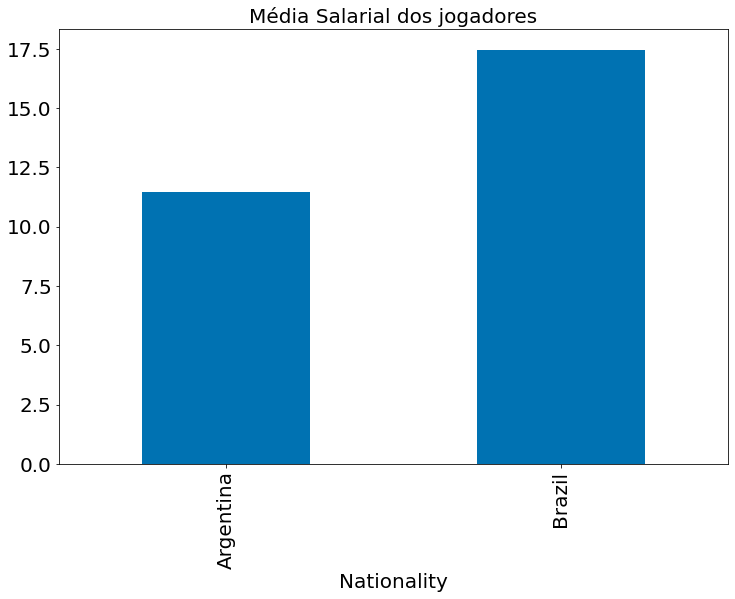

In [22]:
brasilArgentina = data.loc[(data['Nationality'] == 'Brazil') | (data['Nationality'] == 'Argentina')].sort_values('Wage', ascending = False)
brasilArgentina['log_wage'] = np.log(brasilArgentina['Wage'])

meanPlot = brasilArgentina[['Nationality','Wage']].groupby("Nationality").agg([np.mean])
_ = meanPlot.plot(kind = "bar", y = "Wage", legend = False,
            title = "Média Salarial dos jogadores")

Diferença observada:  5.996279730166178


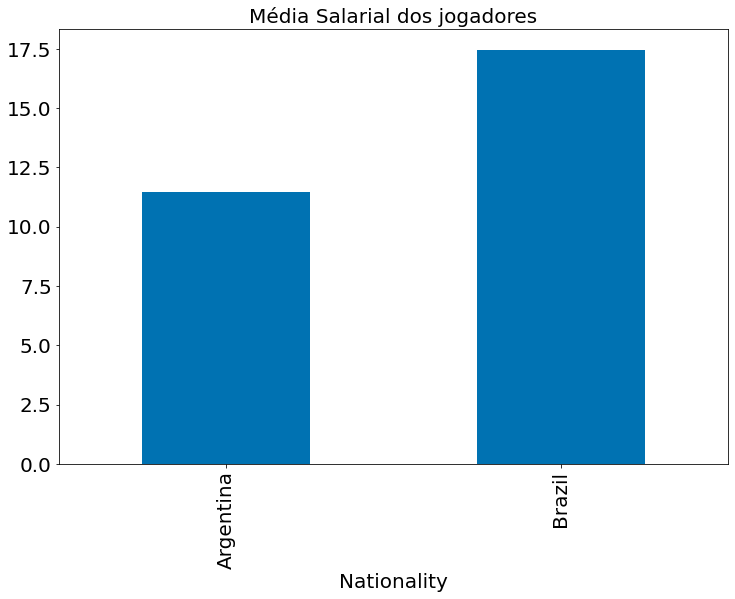

In [23]:
#data = pd.read_csv('fifa.csv', index_col='ID')
brasilArgentina = data.loc[(data['Nationality'] == 'Brazil') | (data['Nationality'] == 'Argentina')].sort_values('Wage', ascending = False)
t_obs = brasilArgentina[brasilArgentina['Nationality'] == 'Brazil']['Wage'].mean() - brasilArgentina[brasilArgentina['Nationality'] != 'Brazil']['Wage'].mean()
print("Diferença observada: ", t_obs)
meanPlot = brasilArgentina[['Nationality','Wage']].groupby("Nationality").agg([np.mean])
_ = meanPlot.plot(kind = "bar", y = "Wage", legend = False,
            title = "Média Salarial dos jogadores")

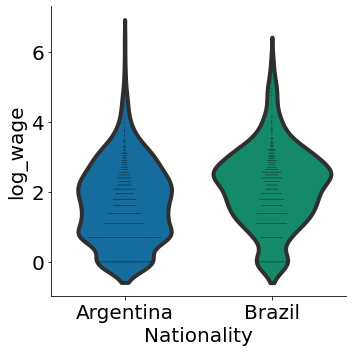

In [24]:
brasilArgentina['log_wage'] = np.log(brasilArgentina['Wage'])
g = sns.catplot(x="Nationality", y="log_wage", kind="violin", inner=None, data=brasilArgentina)
_ = sns.swarmplot(x="Nationality", y="log_wage", color="k", size=0.5, data=brasilArgentina, ax=g.ax)

Pelo violin plot é possível perceber que existem menos jogadores brasileiro que recebem "pouco" comparado aos jogadores argentinos, onde no centro do "violiono" brasileiro é possivel reparar que ele é mais "aberto", representando uma quantidade maior de jogadores com salario "médio".

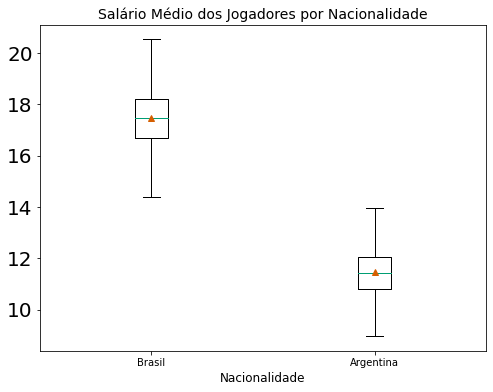

Intervalo de confiança:  3.066616824394732 ,  8.94910744754754
Valores extremos (Brasil):  15.407328680203046 ,  19.863007614213195
Valores extremos (Argentina):  9.824699879951982 ,  13.522298919567826
Calculando o p-valor:
P-Valor:  0.4996


In [25]:
def bootstrap_mean(df1, df2, column, n=5000):
    size1 = len(df1)
    size2 = len(df2)
    values1 = np.zeros(n)
    values2 = np.zeros(n)
    values_diff = np.zeros(n)
    for i in range(n):
        sample1 = df1[column].sample(size1, replace=True, random_state=i)
        sample2 = df2[column].sample(size2, replace=True, random_state=i*3)
        values1[i] = sample1.mean()
        values2[i] = sample2.mean()
        values_diff[i] = sample1.mean() - sample2.mean()
    return values1, values2, values_diff

brasil = brasilArgentina[brasilArgentina['Nationality']=='Brazil']
argentina = brasilArgentina[brasilArgentina['Nationality']=='Argentina']
col = 'Wage'
v_brasil, v_argentina, v_diff = bootstrap_mean(brasil, argentina, col)

bp_data = [v_brasil, v_argentina]
plt.rcParams['figure.figsize']  = (8, 6)
plt.boxplot(bp_data,  positions=[1,2], showfliers=False, showmeans=True)
plt.xticks([1,2], ['Brasil', 'Argentina'], fontsize=10)
plt.ylabel('', fontsize=13)
plt.xlabel('Nacionalidade', fontsize=12)
plt.title('Salário Médio dos Jogadores por Nacionalidade', fontsize=14)
plt.show()


print("Intervalo de confiança: ", np.percentile(v_diff, 2.5), ", ", np.percentile(v_diff, 97.5))
print("Valores extremos (Brasil): ", np.percentile(v_brasil, 2.5), ", ", np.percentile(v_brasil, 97.5))
print("Valores extremos (Argentina): ", np.percentile(v_argentina, 2.5), ", ", np.percentile(v_argentina, 97.5))

k = 0
#p-valor
print("Calculando o p-valor:")
for element in v_diff:
    if element > t_obs:
        k += 1 
p = k / len(v_diff)
print("P-Valor: ",p)

<h4>Calculando o p-valor</h4>
O p-valor 0.4996 é altíssimo, então a hipótese nula não é rejeitada.

**Teste A/B**

Realizando um teste *A/B* sobre os salários (em *log*) dos jogadores, percebemos que com 5% de chance os jogadores brasileiros se encontram com o mesmo salário que os argentinos, verificando que com os dados usados no FIFA nesse ano, os brasileiros ganham mais que os argentinos

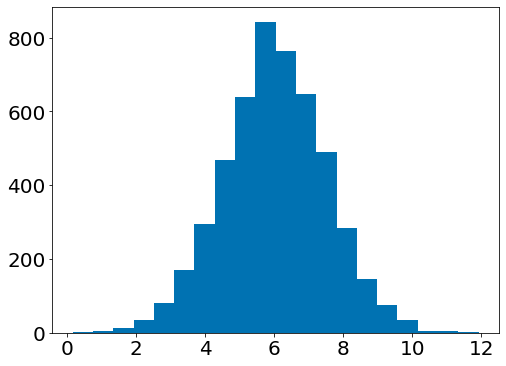

In [26]:
_ = plt.hist(v_diff, bins = 20)

In [27]:
clubes = pd.DataFrame(data.groupby(['Club']).mean()['Wage'])
clubes.sort_values(by='Wage')

,Wage
Club,
Lokomotiv Moscow,1.000000
IF Brommapojkarna,1.000000
Envigado FC,1.000000
Trelleborgs FF,1.000000
FC Carl Zeiss Jena,1.000000
...,...
Manchester United,102.757576
Manchester City,113.363636
Juventus,131.680000


In [28]:
mediaSalarial = clubes['Wage'].mean()
print(mediaSalarial)

8.965544035531927


A média dos clubes é 8.73 mil euros, e alguns clubes ganham muito mais como o Barcelona e o Real Madrid.
Assim podemos fazer uma hipótese sobre isso, será que a chance consegue explicar essa diferença.

Diferença observada:  137.2298213927353
FC Barcelona:  146.57575757575756
Outros Times:  9.345936183022276


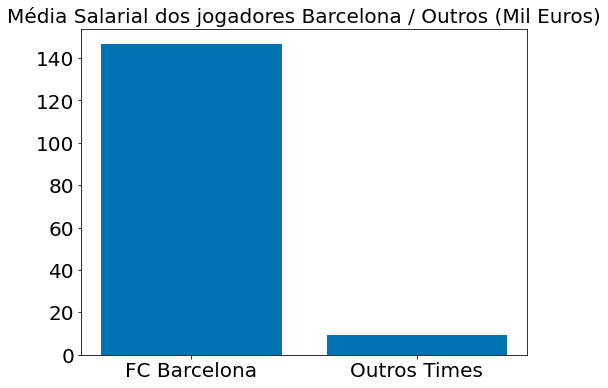

In [29]:
#data = pd.read_csv('fifa.csv', index_col='ID')
times = data
# times[times['Club'] != 'FC Barcelona']
t_obs = times[times['Club'] == 'FC Barcelona']['Wage'].mean() - times[times['Club'] != 'FC Barcelona']['Wage'].mean()
mediaBarcelona = times[times['Club'] == 'FC Barcelona']['Wage'].mean()
mediaOutros = times[times['Club'] != 'FC Barcelona']['Wage'].mean()
print("Diferença observada: ", t_obs)
print("FC Barcelona: ", mediaBarcelona)
print("Outros Times: ", mediaOutros)
# meanPlot = times[['Club','Wage']].groupby("Club").agg([np.mean])
# meanPlot.plot(kind = "bar", y = "Wage", legend = False,
#             title = "Média Salarial dos jogadores Barcelona / Outros (Mil Euros)")
_ = plt.bar(['FC Barcelona', 'Outros Times'], [mediaBarcelona,mediaOutros])
_ = plt.title("Média Salarial dos jogadores Barcelona / Outros (Mil Euros)")

In [30]:
filtro = times['Club'] == 'FC Barcelona'
N = 1000
diferencas =  np.zeros(N)
for i in range(N):
    np.random.shuffle(filtro.values)
    diff = times[filtro]['Wage'].mean() - times[~filtro]['Wage'].mean()
    diferencas[i] = diff

In [31]:
k = 0
for element in diferencas:
    if element > 145:
        k += 1 
p = k / len(diferencas)
print("P-Valor: ",p)

t_obs = times[~filtro]['Wage'].mean() - times[filtro]['Wage'].mean()
print("Média Salarial:", t_obs)

print("Intervalo de confiança: ", np.percentile(diferencas, 2.5), ", ", np.percentile(diferencas, 97.5))

P-Valor:  0.0
Média Salarial: 1.6819787276740925
Intervalo de confiança:  -5.052297812562713 ,  10.983285671282356


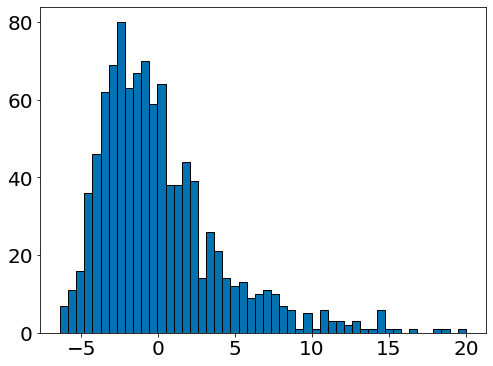

In [32]:
_ = plt.hist(diferencas,bins=50, edgecolor='k')

O P-Valor encontrado foi muito pequeno o que nos leva a rejeitar a hipótese nula. Ou seja,
a diferença salarial entre o Barcelona e os outros times não pode ser explicada pelo acaso.

# Regressões


In [33]:
cols = ['Age', 'Wage']
series = data[cols].groupby('Age', as_index=False).mean()
series

,Age,Wage
0,16,1.170732
1,17,2.147887
2,18,2.134094
3,19,2.413607
4,20,4.111824
5,21,5.631967
6,22,7.533964
7,23,8.124474
8,24,9.577114
9,25,11.310201


In [34]:
plt.rcParams['figure.figsize']  = (18, 10)
plt.rcParams['axes.labelsize']  = 20
plt.rcParams['axes.titlesize']  = 20
plt.rcParams['legend.fontsize'] = 20
plt.rcParams['xtick.labelsize'] = 20
plt.rcParams['ytick.labelsize'] = 20
plt.rcParams['lines.linewidth'] = 4
plt.ion()

plt.style.use('seaborn-colorblind')
plt.rcParams['figure.figsize']  = (12, 8)

ols = ['Age', 'Wage']

series = data[cols].groupby('Age', as_index=False).mean()
series

,Age,Wage
0,16,1.170732
1,17,2.147887
2,18,2.134094
3,19,2.413607
4,20,4.111824
5,21,5.631967
6,22,7.533964
7,23,8.124474
8,24,9.577114
9,25,11.310201


In [35]:
def beta(series, mean_x, mean_y):
    num = 0
    den = 0
    for i in range(len(series)):
        num += (series.iloc[i][0] - mean_x) * (series.iloc[i][1] - mean_y)
        den += (series.iloc[i][0] - mean_x) ** 2
    return num/den

mean_x = np.mean(series['Age'])
mean_y = np.mean(series['Wage'])
beta = beta(series, mean_x, mean_y)
beta

0.07967790390876903

In [36]:
alpha = mean_y - beta*mean_x
alpha

5.836746057155837

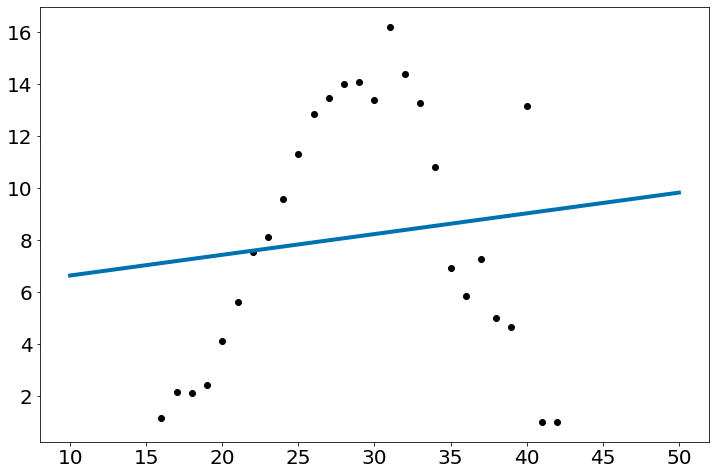

In [37]:
fig,ax = plt.subplots()
x = np.linspace(10.,50.)
ax.plot(x,beta*x+alpha)
x = np.array(series.iloc[:len(series)-1,0].values).reshape((-1,1)) 
y = np.array(series.iloc[:len(series)-1,1].values).reshape((-1,1))
plt.scatter(x,y,color="black")
plt.show()

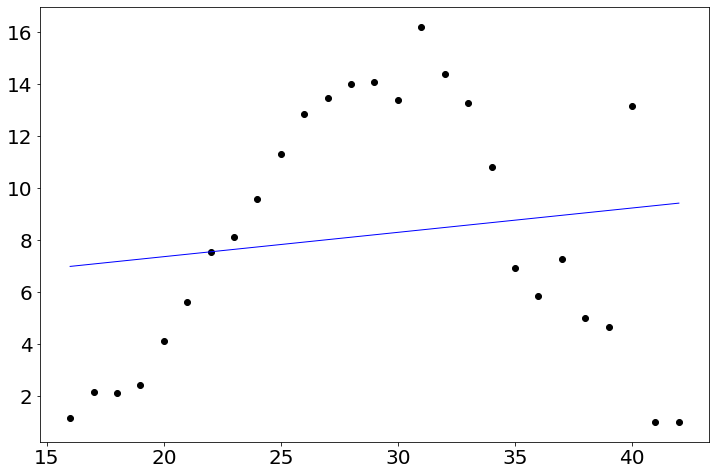

In [38]:
from sklearn.linear_model import LinearRegression

model = LinearRegression()
x = np.array(series.iloc[:len(series)-1,0].values).reshape((-1,1)) 
y = np.array(series.iloc[:len(series)-1,1].values).reshape((-1,1))

model.fit(x,y)
new_y = model.predict(x)
plt.scatter(x,y,color="black")
_ = plt.plot(x,new_y,color="blue", linewidth=1)

In [39]:
from sklearn.preprocessing import PolynomialFeatures
poly_reg = PolynomialFeatures(degree=2)
X_poly = poly_reg.fit_transform(x)

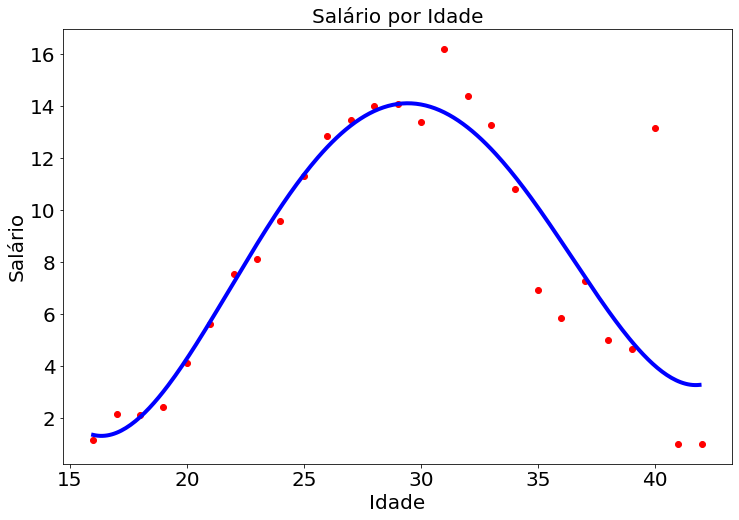

In [40]:
lin_reg2 = LinearRegression()
lin_reg2.fit(X_poly,y)
from sklearn.preprocessing import PolynomialFeatures
poly_reg = PolynomialFeatures(degree=4)
X_poly = poly_reg.fit_transform(x)
lin_reg2 = LinearRegression()
lin_reg2.fit(X_poly,y)
  
X_grid = np.arange(min(x),max(x),0.1)
X_grid = X_grid.reshape(len(X_grid),1) 
plt.scatter(x,y, color='red') 
  
plt.plot(X_grid, lin_reg2.predict(poly_reg.fit_transform(X_grid)),color='blue') 
  
plt.title("Salário por Idade")
plt.xlabel('Idade')
plt.ylabel('Salário')
plt.show()

# Outras Regressões

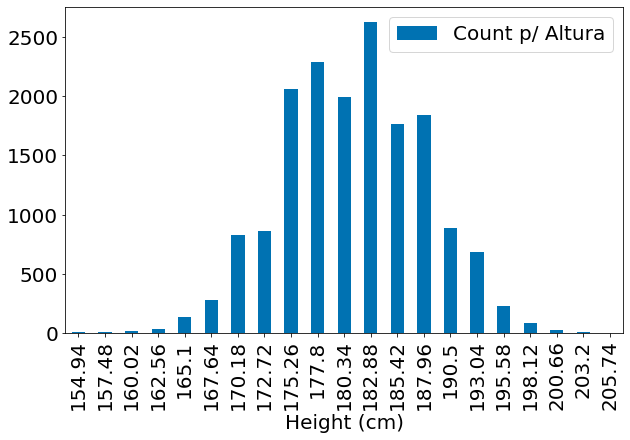

In [56]:
from sklearn.datasets import load_diabetes
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

data.reset_index(drop=True, inplace=True)
s = data[['Height (cm)']].round(2)
s['Count p/ Altura'] = s.groupby('Height (cm)')['Height (cm)'].transform('count')
s = s.sort_values(['Height (cm)'])
j = s.drop_duplicates(subset = ["Height (cm)","Count p/ Altura"])
j.reset_index(inplace=True, drop=True)
_ = j.plot.bar(x='Height (cm)',y='Count p/ Altura',figsize=(10,6))

In [42]:
def error(alpha, beta, x, y):
    return y - alpha - beta*x

def sum_of_squared_errors(alpha, beta, x, y):
    result = 0
    index = 0
    while index < len(y):
      result += (error(alpha,beta,x[index],y[index]))**2
      index += 1
    result = result

    return result

def total_sum_of_squares(y):
    result = 0
    mean = y.mean()

    for element in y:
      result += (element - mean)**2
    result 

    return result

def r_squared(alpha, beta, x, y):
    SQT = total_sum_of_squares(y)
    SQR = sum_of_squared_errors(alpha,beta,x,y)

    return (SQT - SQR)/SQT

In [43]:
def linear_regression(x,y):
  alpha = 0
  beta = 0
  mean_x = x.mean()
  mean_y = y.mean()

  index = 0
  covariancia = 0
  variancia = 0
  while index < len(y):
    covariancia += (x[index] - mean_x)*(y[index] - mean_y)
    index += 1
  covariancia = covariancia/len(y)
  index = 0
  while index < len(x):
    variancia += (x[index] - mean_x)**2
    index += 1
  variancia = variancia/len(x)
  beta = covariancia/variancia
  alpha = mean_y - beta*mean_x

  return (alpha, beta)

In [44]:
def correlacao(x_name,y_name):
  x = data[x_name]
  y = data[y_name]
  x = x[:10000]
  y = y[:10000]
  (alpha,beta) = linear_regression(x,y)
  print("Alpha , Beta:")
  print((alpha,beta))
  print("Coeficiente de Determinação:")
  print(r_squared(alpha,beta,x,y))
  _ = plt.plot(data[x_name], data[y_name],'o')
  _ = plt.plot(data[x_name], alpha + beta*data[x_name], color='r')

Alpha , Beta:
(1.1838605601221062, 0.20630206836667345)
Coeficiente de Determinação:
0.012019333770832141


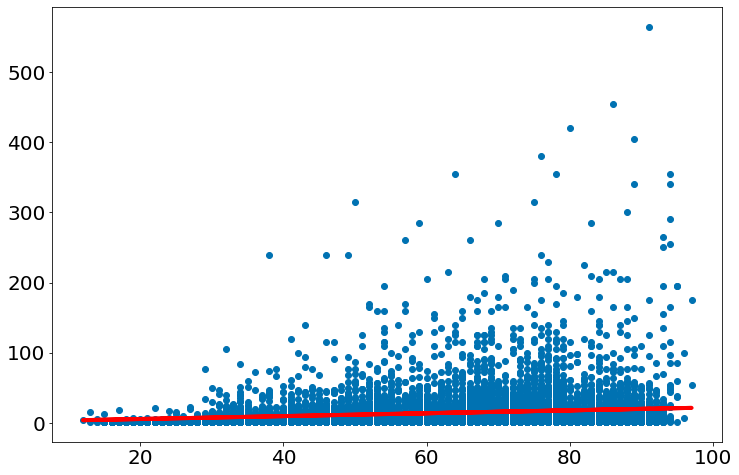

In [45]:
correlacao('Acceleration','Wage')

Alpha , Beta:
(1.2893949224125993, 0.07483094012007548)
Coeficiente de Determinação:
0.0003337817495869934


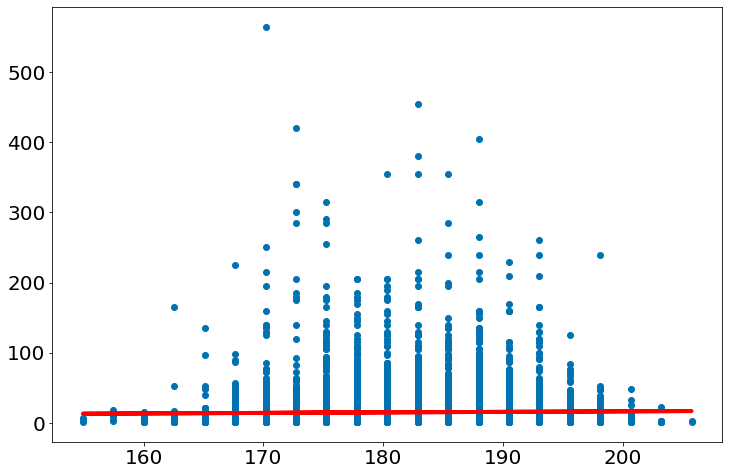

In [46]:
correlacao('Height (cm)','Wage')

Alpha , Beta:
(7.416935741291074, 0.14529941518405057)
Coeficiente de Determinação:
0.011449885987677173


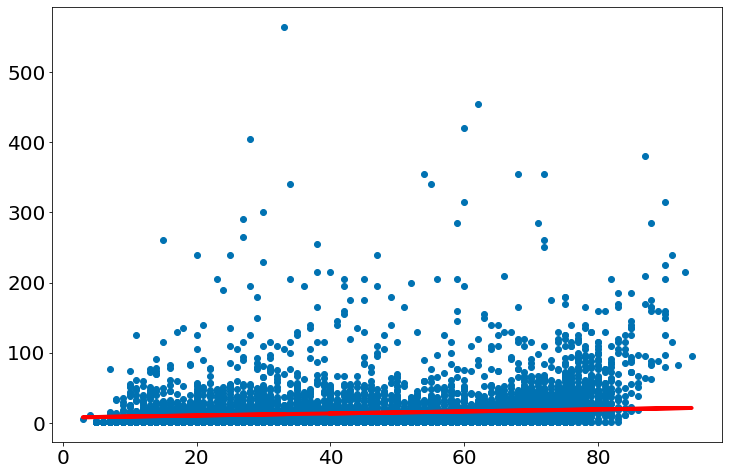

In [47]:
correlacao('Marking','Wage')

Alpha , Beta:
(3.799713002420873, 0.17072168364949722)
Coeficiente de Determinação:
0.007692334128370988


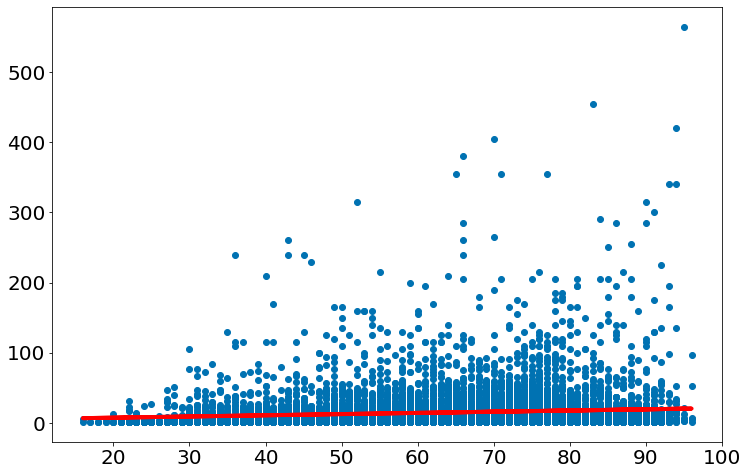

In [48]:
correlacao('Balance','Wage')

Alpha , Beta:
(7.183454463098503, 0.14915353867146558)
Coeficiente de Determinação:
0.012743811751549932


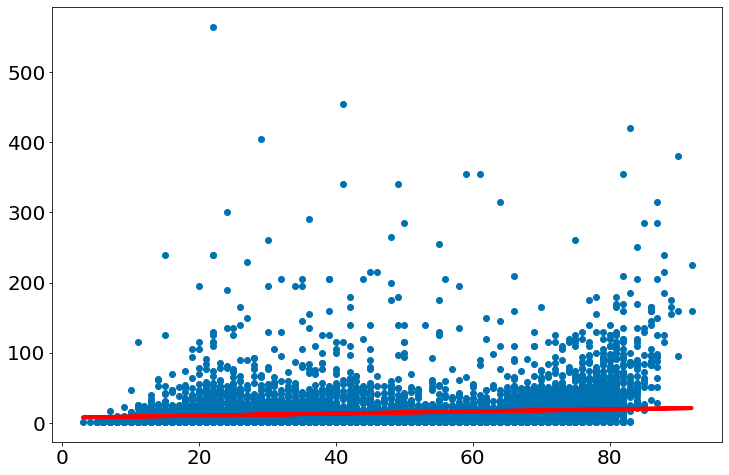

In [49]:
correlacao('Interceptions','Wage')

Alpha , Beta:
(2.8328510900241266, 0.17562768206819349)
Coeficiente de Determinação:
0.005479718811433687


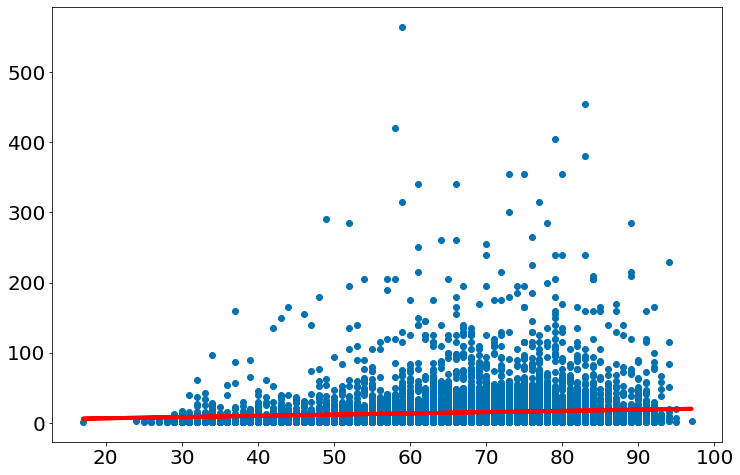

In [50]:
correlacao('Strength','Wage')

Alpha , Beta:
(-114.98543951428381, 1.0115224142027164)
Coeficiente de Determinação:
0.34330400570199


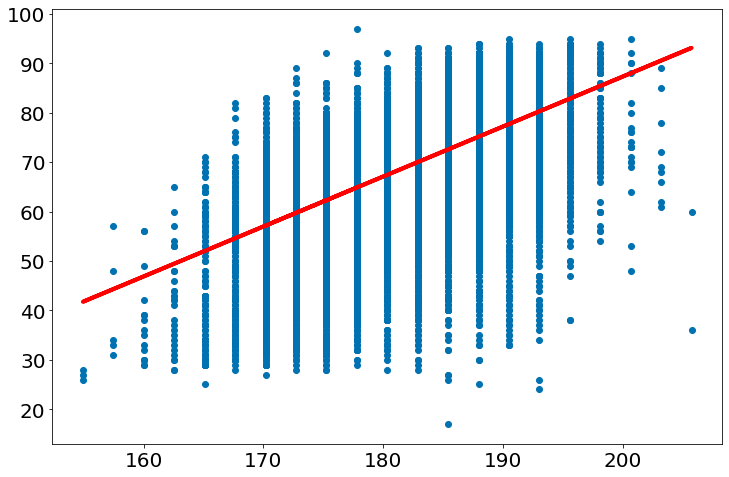

In [51]:
correlacao('Height (cm)','Strength')

# Previsão



In [52]:
#Pegar as colunas que serão usadas na classificação
#features = ['Overall']
features = ['ShortPassing','LongPassing','Reactions','Vision','Composure']
# features = data.columns[22:-1]
# Número de folds da validação cruzada
SPLITS = 5

X = data[features].values
y = data[['Wage']].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=40)

In [53]:
# YOUR CODE HERE
# Feature Scaling for input features.
scaler = preprocessing.MinMaxScaler()
X_scaled = scaler.fit_transform(X)
# Create StratifiedKFold object.
skf = StratifiedKFold(n_splits=SPLITS, shuffle=True, random_state=1)

In [54]:
print("KNN")
contador = 0
jogador = [[90,50,70,80,30]]
for train_index, test_index in skf.split(X, y):
    X_train_fold, X_test_fold = X_scaled[train_index], X_scaled[test_index]
    y_train_fold, y_test_fold = y[train_index], y[test_index]
    contador = contador + 1
    print("Fold", contador)
    for i in [5,15, 25,1000]:
      knn = KNeighborsRegressor(n_neighbors=i)
      knn.fit(X_train_fold, y_train_fold)
      y_pred1 = knn.predict(X_test)
      previsao = knn.predict(jogador)
      mean_squared_error = np.mean((y_pred1 - y_test)**2)
      print(i,"Vizinhos | Erro quadrado médio: ", mean_squared_error)
      print("Salario previsto para o jogador:", previsao)
    print("\n")

KNN
Fold 1
5 Vizinhos | Erro quadrado médio:  71895.33684589967
Salario previsto para o jogador: [[244.2]]
15 Vizinhos | Erro quadrado médio:  50661.63699742999
Salario previsto para o jogador: [[223.93333333]]
25 Vizinhos | Erro quadrado médio:  38831.946060919196
Salario previsto para o jogador: [[201.]]
1000 Vizinhos | Erro quadrado médio:  1849.2349479474317
Salario previsto para o jogador: [[46.503]]


Fold 2
5 Vizinhos | Erro quadrado médio:  105058.59007509761
Salario previsto para o jogador: [[340.2]]
15 Vizinhos | Erro quadrado médio:  57281.71992924136
Salario previsto para o jogador: [[244.26666667]]
25 Vizinhos | Erro quadrado médio:  39043.7036803845
Salario previsto para o jogador: [[190.64]]
1000 Vizinhos | Erro quadrado médio:  1887.8113280426555
Salario previsto para o jogador: [[46.878]]


Fold 3
5 Vizinhos | Erro quadrado médio:  129123.7491739261
Salario previsto para o jogador: [[366.]]
15 Vizinhos | Erro quadrado médio:  65278.49005306899
Salario previsto para o j

<h3>Previsão Usando KNVizinhos</h3>

Ao utilizar o algoritmo de KNN na nossa base de dados conseguimos verificar algumas informações tanto sobre os salarios dos jogadores quanto a própria base de dados.

No salário dos jogadores podemos ver que a maioria dos jogadores ganham pouco, isso pode ser visto no KNN quando aumentamos a quantidade de vizinhos o salario de um jogador previsto diminui relativo ao aumento quantidade.

O erro médio do KNN nos mostra que a previsão usando somente os atributos *ShortPassing, LongPassing, Reactions, Vision, Composure*, não retorna uma previsão util em relação ao salário do jogador, pois a tabela tem um total de 56 atributos e usando somente 6 dos mesmos não é possivel aproximar um valor correto do salário dos jogadores